# A Web Service of Time Series of Earth Observation Data

## Context: The e-sensing project

The e-sensing project is about developing new ways to extract information on land use and land cover change from big Earth Observation data sets. We address the following scientific question: 

***How can we use e-science methods and techniques to improve the extraction of land use and land cover change information from big Earth Observation data sets in an open and reproducible way?*** 

To answer this, our project is building a new generation of knowledge platform for handling big geospatial data. We're conceiving, building, and deploying a new type of knowledge platform for accessing, processing and analyzing big Earth Observation data.

We assume that decades of satellite images can be effectively organized into a data structure which can be efficiently queried and processed using the array data model. 

<img src="img/datacube.png" alt="A data cube of satellite images is as an array" title="data cube" height="300" width="400" />

Our approach is to put data and analysis together to help scientists to do larger, longer, and faster research on land use and land cover change.

<img src="img/architecture.png" alt="e-sensing project's architecture " title="e-sensing architecture" height="300" width="400" />

The "e-sensing" project is supported by __[FAPESP](http://bv.fapesp.br/pt/auxilios/89598/e-sensing-analise-de-grandes-volumes-de-dados-de-observacao-da-terra-para-informacao-de-mudancas-de/)__, under the  __[e-science program](http://www.fapesp.br/8436)__ .

For additional information, please visits us at:

- our  __[official page](http://esensing.org/)__ 
- our code repository at __[github](https://github.com/e-sensing/)__
- our project at __[research gate](https://www.researchgate.net/project/e-sensing-big-earth-observation-data-analytics-for-land-use-and-land-cover-change-information-wwwesensingorg)__


## Web Time Series Service

The Web Time Series Service (WTSS) is a lightweight web service for handling time series data from remote sensing imagery. It exposes three operations:
- ```list_coverages```: get the list of available coverages.
- ```describe_coverage```: get metadata about a specific coverage.
- ```time_series```: get a time series for a given location and time interval.

WTSS is developed and maintained by the National Institute for Space Research of Brazil __[INPE](http://www.inpe.br/)__, where we have a WTSS instance running.

For additional details such as the source code and the WTSS clients for Python, R, Javascript and C++ go to the __[WTSS repository](https://github.com/e-sensing/tws/tree/master/src/tws/wtss)__. 

If you are interested on setting your own WTSS, you can contact us through the __[e-sensing](http://esensing.org/)__ links provided above.

## WTSS for Python

The __[python client](https://github.com/e-sensing/wtss.py)__ for WTSS enables users to retrieve time series of Earth observation data for specific locations. Using a few lines of code, you can retrieve data from Earth observation.
 WTSS easily integrates with Python analysis libraries such as __[numpy](http://www.numpy.org)__, __[scipy](https://www.scipy.org)__, __[pandas](http://pandas.pydata.org)__ and __[matplotlib](https://matplotlib.org)__.

### WTSS: List coverages

This operation gets a list of the data sets hosted in the WTSS. In the example below, we import the WTSS module and then create a WTSS object to query and print the list of available data sets in the server.

In [ ]:
from wtss import wtss

# WTSS python client: Access to data & metadata
w = wtss("http://www.dpi.inpe.br/tws")

# print the available data sets
cv_list = w.list_coverages()
for cv_name in cv_list["coverages"]:
    print(cv_name)

### WTSS: Describe coverage

This operations enables users to explore the details of a data set in the WTSS. Below, we ask WTSS for the details of a coverage. Then we format and print the WTSS's reponse.

In [ ]:
# explore a WTSS data set
cv_scheme = w.describe_coverage("mod13q1_512")

# format response
print("ARRAY: {}".format(cv_scheme["name"]))
print("\nDESCRIPTION:\n" + str(cv_scheme['description']) + " - " + str(cv_scheme['detail']))
print("\nDIMENSIONS:{}\n".format(cv_scheme['dimensions']))
print("\nSPATIAL EXTENT:{}\n".format(cv_scheme['spatial_extent']))
print("\nCRS:{}\n".format(cv_scheme['crs']['wkt']))
print("\nTIMELINE:\nFirst five: {}...\nLast  five: ...{}".format(cv_scheme['timeline'][0:5], cv_scheme['timeline'][-5:]))

print("\nATTRIBUTES:")

for att in cv_scheme['attributes']:
    print("{}: {}. Type: {}".format(att['name'], att['description'], att['datatype']))

### WTSS: Time series

This operation retrieves a time series of the provided point. Here, we ask WTSS for some vegetation indexes, then we create *pandas* series out of them, and finally we put the series together into a *pandas* data frame.

In [ ]:
import pandas as pd

point = {'lat': -12.0, 'lon': -54.0}
# get time series of a point
ts = w.time_series("mod13q1_512", ("ndvi", "evi"), point['lat'], point['lon'])

# build a data frame made of vegetation indexes
ndvi = pd.Series(ts["ndvi"], index = ts.timeline)/10000
evi  = pd.Series(ts["evi"],  index = ts.timeline)/10000

vidf = pd.DataFrame({'ndvi': ndvi, 'evi': evi})
vidf[0:5]

In [ ]:
import folium
import vincent
import pandas

map = folium.Map(location=point.items(), zoom_start=6)

df = vidf;
df.index = df.index.values.astype('M8[D]')
chart = vincent.Line(df[['evi','ndvi']],width=300,height=150)
chart.axis_titles(x='dates', y='') 

popup = folium.Popup(max_width=400)
folium.Vega(chart.to_json(), height=200, width=350).add_to(popup)
folium.Marker(point.items(), popup=popup).add_to(map)
map

## WTSS and Python Data Analysis Library (pandas)

### Data visualization

Python provides tools for scientific data visualization. Below, we take advantage of the integration between *pandas* and *matplotlib* in order to plot our vegetation indexes.

In [ ]:
%matplotlib inline

import matplotlib
from cycler import cycler

matplotlib.style.use('ggplot')
# Updating default plot colors
colors = cycler(u'color', [u'#74c476',u'#6baed6',u'#d62728', u'#ff7f0e', u'#756bb1'])
matplotlib.rcParams['axes.prop_cycle'] = colors

# Time series visualization
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
ax.legend()
fig.autofmt_xdate()

### Line fitting

A simple way to reveal coarse trends in time series is to adjust a straight line through the data. In the code below, we have a function to fit lines which we use in our time series. Then we plot the vegetation indexes along the adjusted lines.

In [ ]:
from scipy import stats

# fit a line to a time series
def fitline(vi):
    """!
    Fit a line to a time series.
    @param vi pandas.Series: A time series
    @return   Return a numpy.ndarray with the values of the fitted line for each element in vi.
    """
    vi = pd.Series(vi.values, index = range(len(vi.values)))                       # re-build the series
    obid = pd.Series(range(len(vi.values)), index = range(len(vi.values)))         # add an index to the series
    sl, it, r, p, sde = stats.linregress(x = range(len(vi.values)), y = vi.values) # fit the line
    lmdf = pd.DataFrame({'obid': obid, 'vi': vi})                                  # build a data frame
    lmdf['vi_lm'] = lmdf['obid'] * sl + it                                         # compute the line's points
    return(lmdf['vi_lm'].values)

In [ ]:
# fit a line to the vegetation indexes
vidf['ndvi_lm'] = fitline(vidf['ndvi'])
vidf['evi_lm'] = fitline(vidf['evi'])

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_lm'].plot()
vidf['evi_lm'].plot()
ax.legend()
fig.autofmt_xdate()
vidf[0:5]

### Fourier decomposition

Fourier series analysis allow us to decompose time series into a sum of waves represented by periodic functions. These functions have properties such as amplitude, wavelength, and frequency. In time series analysis, it is accepted that high frequencies are associated with noise. Therefore, in order to diminish noise we need to remove high frequencies from our time series. 

In the example below, the Fourier filter function removes any trend in the data by fitting a line, then it computes the Fast Fourier Transform (FFT), then it removes the frequencies higher than a given threshold, and finally computes the Inverse FFT to re-build a smoother time series.

In [ ]:
import numpy as np

# Fourier decomposition
def fourierfilter(vi, fq_keep):
    """!
    Filter a time series using Fourier decomposition.
    @param vi      pandas.Series: A time series
    @param fq_keep int: The number of low frequencies to keep
    @return        Return a numpy.ndarray with filtered values for each element in vi.
    """
    vi = pd.Series(vi.values, index = range(len(vi.values)))               # re-build the series
    fdf = pd.DataFrame({'vi': vi})
    ## de-trend the time series by fitting a trend line
    fdf['vi_lm'] = fitline(fdf['vi'])
    fdf['residual'] = fdf['vi'] - fdf['vi_lm']
    # compute the discrete Fourier Transform
    vi_fft = np.fft.fft(fdf['residual'].values).real
    # remove the frequencies from index fq_keep to the last one
    vi_fft[fq_keep:] = 0
    # compute the inverse discrete Fourier Transform
    vi_ifft = np.fft.ifft(vi_fft).real
    # add the residuals back
    return(vi_ifft + fdf['vi_lm'].values)

In [ ]:
# filter the vi
vidf['ndvi_ff'] = fourierfilter(vidf['ndvi'], 25)
vidf['evi_ff'] = fourierfilter(vidf['evi'], 45)

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_ff'].plot()
vidf['evi_ff'].plot()
ax.legend()
fig.autofmt_xdate()
vidf[0:5]

### Whittaker smoothing filter

Whitakker filter is obtained by a linear combination of time series nearest neighbors points measures [[Eilers2003]](#references). 

In [ ]:
# This is a function that implements a Whittaker smoother in Python. 
# Source: https://gist.github.com/zmeri/3c43d3b98a00c02f81c2ab1aaacc3a49

import scipy
import scipy.sparse.linalg


def whittaker_filter(y, lmda=1.0):
    m = len(y)
    E = scipy.sparse.identity(m)
    d1 = -1 * np.ones((m), dtype='d')
    d2 = 3 * np.ones((m), dtype='d')
    d3 = -3 * np.ones((m), dtype='d')
    d4 = np.ones((m), dtype='d')
    D = scipy.sparse.diags([d1, d2, d3, d4], [0, 1, 2, 3], shape=(m - 3, m), format="csr")
    z = scipy.sparse.linalg.cg(E + lmda * (D.transpose()).dot(D), y)
    return z[0]

In [ ]:
# filter the vi
vidf['ndvi_wf'] = pd.Series(whittaker_filter(ndvi), index = ts.timeline)
vidf['evi_wf']  = pd.Series(whittaker_filter(evi), index = ts.timeline)

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_wf'].plot()
vidf['evi_wf'].plot()
ax.legend()
fig.autofmt_xdate()
vidf[0:5]

### Kalman filter

The Kalman filter aims to separate time series from noise. It is an iterative algorithm on which the outputs of one iteration are the inputs for the next one. In this way, the filter successively improves its estimations of the true value of a time series. 

In the example below, we estimate the initial parameters for the filter from the time series itself. Then we compute the Kalman filter and plot the smoothed vegetation indexes.

In [ ]:
# Kalman filter
def kalmanfilter(vi, e_mea = None, est_0 = None, e_est_0 = None):
    """!
    Filter a time series using the Kalman filter.
    @param vi      pandas.Series: A time series made of measurements
    @param e_mea   int: The error in the measurements
    @param est_0   int: The estimate of the first measurement
    @param e_est_0 int: The initial error in the estimate
    @return        Return a numpy.ndarray with filtered values for each element in vi.
    """
    est   = np.zeros(len(vi)) # estimation
    e_est = np.zeros(len(vi)) # error in estimation
    kg    = np.zeros(len(vi)) # Kalman gain
    # deal with missing values
    if est_0 is None:
        est[0]   = vi.mean()
    else:
        est[0]   = est_0
    if e_mea is None:
        e_mea = vi.std()
    if e_est_0 is None:
        e_est[0] = 3 * vi.std()
    else:
        e_est[0] = e_est_0
    # do the filtering
    kg[0]    = None
    for i in range(1, len(vi)):
        kg[i] = e_est[i - 1]/(e_est[i - 1] + e_mea)    # compute the Kalman gain
        m = vi[i - 1]
        if(np.isnan(m)):
            m = est[i - 1]                             # use the estimation when a measurement is missing
        est[i] = est[i - 1] + kg[i] * (m - est[i - 1]) # compute the new estimation
        e_est[i] = (1 - kg[i]) * e_est[i - 1]
    return est

In [ ]:
# filter the vi
vidf['ndvi_kf'] = pd.Series(kalmanfilter(ndvi), index = ts.timeline)
vidf['evi_kf']  = pd.Series(kalmanfilter(evi), index = ts.timeline)

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_kf'].plot()
vidf['evi_kf'].plot()
ax.legend()
fig.autofmt_xdate()
vidf[0:5]

### Dynamic Time Warping

Dynamic Time Warping (DTW) is a shape-based distance function that minimizes distances between two time series by warping time dimension. DTW allows time series comparisons of different length. Here, we use DTW distance in nearest pattern classifier to provide an overview of its versatility. 

Our experiment consists of 10 ground truth samples of labels `Forest` (5) and `Cerrado` (5), taken from Brazilian state of Mato Grosso. We provide the respective prototypes for each land cover class, obtained elsewere (Ref). We applied DTW distance function on all pairs of both samples and patterns data set to compose a dissimilarity matrix from which we extracted the predictors land cover classes.  

In [ ]:
# DTW and classification functions
from dtw import *

# functions to get time series from wtss and plotting time series samples 
from tools import *

Above modules implements functions that simplifies our next code.
You can read them in following links: 
- [dtw.py](./dtw.py)
- [tools.py](./tools.py)

In [15]:
# open samples from file
samples = pd.read_csv("examples/samples.csv")

samples[3:7]

In [16]:
# wtss_get_time_series function is implemented in 'tools.py'
samples_ts = wtss_get_time_series(samples)

# rescale vegetation index to -1.0~1.0 range
samples_ts["ndvi"] *= 0.0001
samples_ts["evi"] *= 0.0001

samples_ts[1:5]

,id,label,start_date,latitude,longitude,timeline,ndvi,evi
1,0,Cerrado,2014-09-14,-14.0482,-54.2313,2014-09-30,0.4196,0.2004
2,0,Cerrado,2014-09-14,-14.0482,-54.2313,2014-10-16,0.3307,0.1971
3,0,Cerrado,2014-09-14,-14.0482,-54.2313,2014-11-01,0.6166,0.4209
4,0,Cerrado,2014-09-14,-14.0482,-54.2313,2014-11-17,0.4662,0.1503


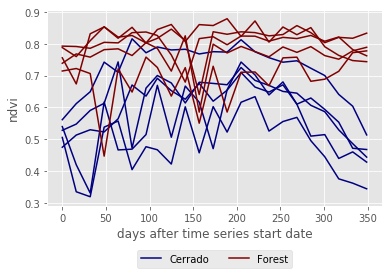

In [17]:
# plot samples time series
plot_time_series(samples_ts)

In [18]:
# open patterns from file
# these patterns were extracted using GAM on a larger data set 
patterns_ts = pd.read_json("examples/patterns.json", orient='records')
# update timeline type from str to datetime
patterns_ts["timeline"] = pd.to_datetime(patterns_ts["timeline"])

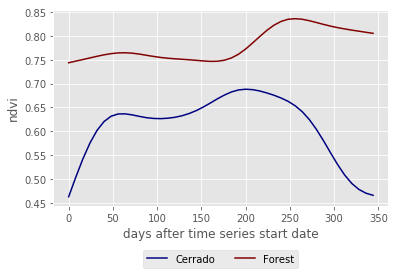

In [19]:
# plot patterns time series
plot_time_series(patterns_ts)

In [20]:
classification = classifier_1nn(patterns_ts, samples_ts)

classification

,id,reference,prediction,correct
0,0,Cerrado,Cerrado,True
1,1,Cerrado,Cerrado,True
2,2,Cerrado,Cerrado,True
3,3,Cerrado,Forest,False
4,4,Cerrado,Cerrado,True
5,5,Forest,Forest,True
6,6,Forest,Forest,True
7,7,Forest,Forest,True
8,8,Forest,Forest,True
9,9,Forest,Forest,True


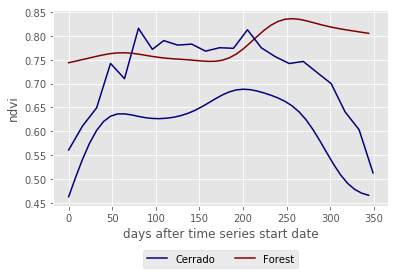

In [21]:
# let see what happened with sample #3
plot_time_series(pd.concat([samples_ts[samples_ts["id"].isin([3])], patterns_ts]))

## Final remarks

We introduced the Web Time Series Service (WTSS), a light weight Web Service of time series of Earth observation data. Through examples and code, we show how the WTSS is used and integrated with Python's scientific libraries such as NumPy, SciPy and Pandas. We demonstrated how WTSS fits into the analytic work flow of Earth Observation Scientists by using it to obtain and filter data.

What are the constraints of WTSS?
- So far, our WTSS implementation only provides data from MODIS __[MOD13Q1](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1)__
- The WTSS interface is still simple, we need to extend the service in order to serve complex applications

What is missing?
- Today, in terms of Map Algebra, WTSS enables local operations. We need to extend it to focal, zonal and global operations.
- WTSS is about time series analysis. But we still need to see cubes of satellite data as images. In other words, we need the equivalent of Web Mapping Server, Web Feature Service, and Web Coverage Server for big Earth observation data.
- Our Array database cluster (SciDB) is slow for retrieving images and it does not have native support for the spatio-temporal metadata associated with Earth observation imagery

Finally, we would like to invite you to explore some results of the **e-sensing** project by clicking __[here](http://terrabrasilis.info/composer/E-SENSING)__. We are working on new features of WTSS and also a new Web Service for processing large amounts of Earth observation data.

# References

<a id="references"></a>
[Eilers2003]: Paul H. C. Eilers. "A Perfect Smoother". Analytical Chemistry, 2003, 75 (14), pp 3631–3636.